In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import layer, losses
from src.model import Model
from src.utils import split_batch, train_step, test_step

In [2]:
data_df = pd.read_csv('energy_efficiency_data.csv')

data_x_df = data_df.drop(['Heating Load', 'Cooling Load'], axis=1)
data_x_df = pd.get_dummies(data_x_df,
                           columns=['Orientation', 'Glazing Area Distribution'],
                           dtype=float)

data_df = pd.concat(
    [data_x_df, data_df['Heating Load']],
    axis=1,
)

data_df


,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Orientation_2.0,Orientation_3.0,Orientation_4.0,Orientation_5.0,Glazing Area Distribution_0.0,Glazing Area Distribution_1.0,Glazing Area Distribution_2.0,Glazing Area Distribution_3.0,Glazing Area Distribution_4.0,Glazing Area Distribution_5.0,Heating Load
0,0.98,514.5,294.0,110.25,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.55
1,0.98,514.5,294.0,110.25,7.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.55
2,0.98,514.5,294.0,110.25,7.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,15.55
3,0.90,563.5,318.5,122.50,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20.84
4,0.90,563.5,318.5,122.50,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.71,710.5,269.5,220.50,3.5,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.43
764,0.69,735.0,294.0,220.50,3.5,0.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.28
765,0.66,759.5,318.5,220.50,3.5,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.92
766,0.64,784.0,343.0,220.50,3.5,0.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.19


In [3]:
dataset = np.array(data_df)
np.random.default_rng().shuffle(dataset)

train_ratio = 0.75
train_size = int(len(dataset) * train_ratio)

train_feature = dataset[:train_size, :-1]
train_mean = np.mean(train_feature, axis=0)
train_std = np.std(train_feature, axis=0)
train_feature = (train_feature - train_mean) / train_std

test_feature = (dataset[train_size:, :-1] - train_mean) / train_std

train_target = dataset[:train_size, -1:]
test_target = dataset[train_size:, -1:]

In [4]:
INPUT_FEATURES = train_feature.shape[1]

model = Model([
    layer.Linear(INPUT_FEATURES, 16),
    layer.Sigmoid(),
    layer.Linear(16, 4),
    layer.Sigmoid(),
    layer.Linear(4, 1),
])

mse = losses.MSE()

In [5]:
EPOCHES = 5000
BATCH_SIZE = 2**7

train_rms, test_rms = [], []
for epoch in range(EPOCHES):

    train_iter_rms, test_iter_rms = [], []
    for x, y in split_batch(train_feature, train_target, BATCH_SIZE):
        train_loss = train_step(x, y, model, mse, learning_rate=0.01)
        train_iter_rms.append(np.sqrt(train_loss))
    train_rms.append(np.mean(train_iter_rms))

    for x, y in split_batch(test_feature, test_target, BATCH_SIZE):
        test_loss = test_step(x, y, model, mse)
        test_iter_rms.append(np.sqrt(test_loss))
    test_rms.append(np.mean(test_iter_rms))

    if (epoch + 1) % 1000 == 0:
        print(
            f'Epoch {epoch}: train loss {train_rms[-1]}, test loss {test_rms[-1]}'
        )


Epoch 999: train loss 0.540492683684944, test loss 0.8494426110661698
Epoch 1999: train loss 0.36047696775430144, test loss 0.7232028125107478
Epoch 2999: train loss 0.3024594703201872, test loss 0.6204229199352468
Epoch 3999: train loss 0.2766806681667253, test loss 0.570541569198565
Epoch 4999: train loss 0.26152865027455163, test loss 0.5419768504567669


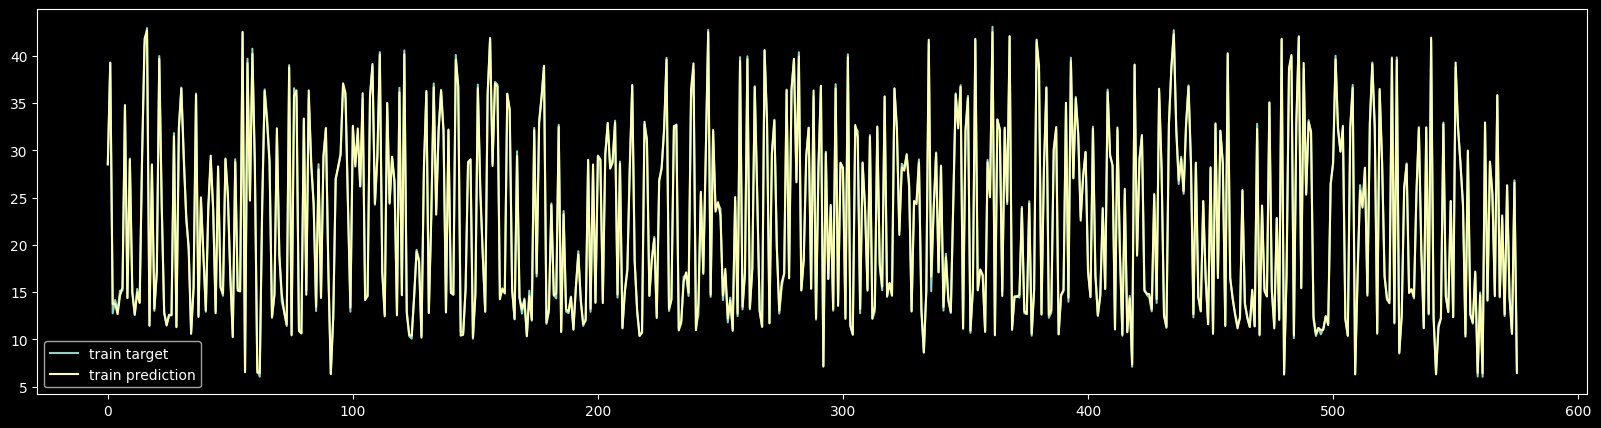

In [6]:
import os

os.makedirs(os.path.join('images', 'regression'), exist_ok=True)

plt.figure(figsize=(20, 5))
plt.plot(train_target, label='train target')
plt.plot(model(train_feature), label='train prediction')
plt.legend()
plt.savefig(os.path.join('images', 'regression', 'train_pred.png'),
            bbox_inches='tight')


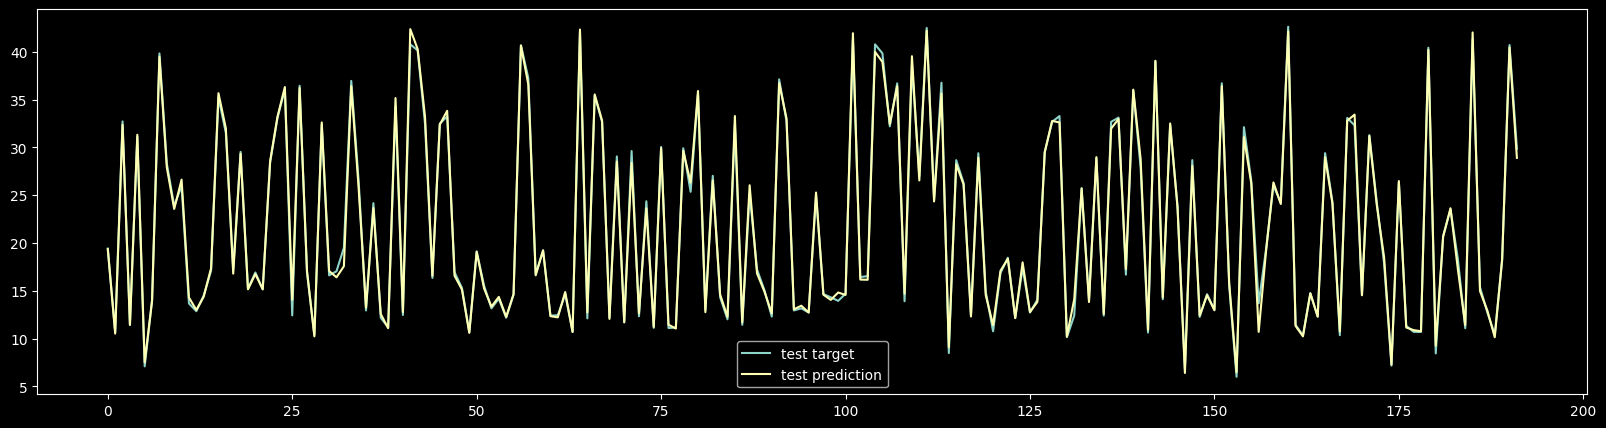

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(test_target, label='test target')
plt.plot(model(test_feature), label='test prediction')
plt.legend()
plt.savefig(os.path.join('images', 'regression', 'test_pred.png'),
            bbox_inches='tight')


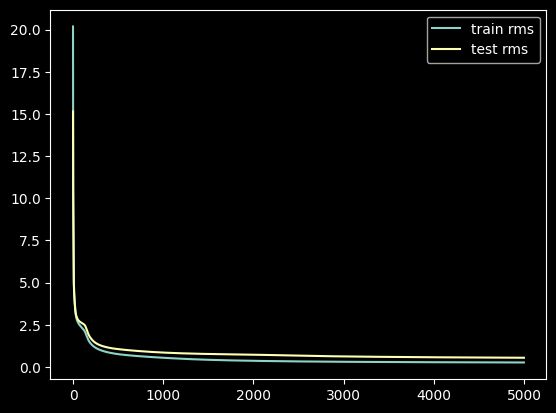

In [8]:
plt.plot(train_rms, label='train rms')
plt.plot(test_rms, label='test rms')
plt.legend()
plt.savefig(os.path.join('images', 'regression', 'loss.png'),
            bbox_inches='tight')


In [9]:
def remain_features(feature, idx):
    feat = np.zeros_like(feature)
    feat[:, idx] = feature[:, idx]
    return feat


In [10]:
features_idx = {
    'Relative Compactness': [0],
    'Surface Area': [1],
    'Wall Area': [2],
    'Roof Area': [3],
    'Overall Height': [4],
    'Glazing Area': [5],
    'Orientation': [6, 7, 8, 9],
    'Glazing Area Distribution': [10, 11, 12, 13, 14, 15],
}

In [11]:
features_rms = {}

for feature_name, idx in features_idx.items():
    feature = remain_features(train_feature, idx)
    features_rms[feature_name] = np.sqrt(
        test_step(feature, train_target, model, mse))

feature_importance = [
    feat_name
    for feat_name, rms in sorted(features_rms.items(), key=lambda x: x[1])
]
print(f'Feature importance: {" > ".join(feature_importance)}')


Feature importance: Overall Height > Relative Compactness > Glazing Area > Glazing Area Distribution > Roof Area > Orientation > Wall Area > Surface Area
